# Zillow Zestimate: Exploratory Data Analysis
This will be an Exploratory Data Analysis (EDA) on the Zillow dataset by George Seif

### Part 3! Lets make the imports and load up the data we were using last time

In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline 

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Load each data file
train_df = pd.read_csv("data/train_2016_v2.csv", parse_dates=["transactiondate"])
prop_df = pd.read_csv("data/properties_2016.csv")

# Merge them
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')

# Let us just impute the missing values with mean values to compute correlation coefficients 
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables 
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

# Select the variables with the highest correlation magnitude
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.005)]

Last time in Part 2 of our series, we saw that there were several features variables that were of particular importance due to their high magintude of correlation coefficient with our target output. Let's print those out again to refresh

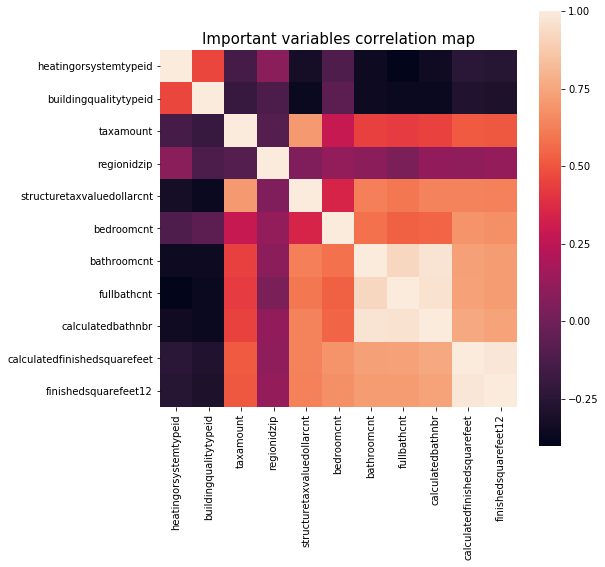

In [43]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [44]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.005)]
corr_df_sel

,col_labels,corr_values
21,heatingorsystemtypeid,-0.019648
6,buildingqualitytypeid,-0.007880
49,taxamount,-0.006671
35,regionidzip,-0.006498
45,structuretaxvaluedollarcnt,0.021935
4,bedroomcnt,0.025467
3,bathroomcnt,0.027889
18,fullbathcnt,0.028169
7,calculatedbathnbr,0.028758
10,calculatedfinishedsquarefeet,0.038341


Sweet!

Now that we have those layed out in front of us, lets look at each of them in detail to see if we can observe any key trends

### Finished SquareFeet

Let's start off with the square footage of the house since it has the highest correlation coefficient. We'll plot the square footage vs log error and see if we can find any key patterns

<Figure size 864x864 with 0 Axes>

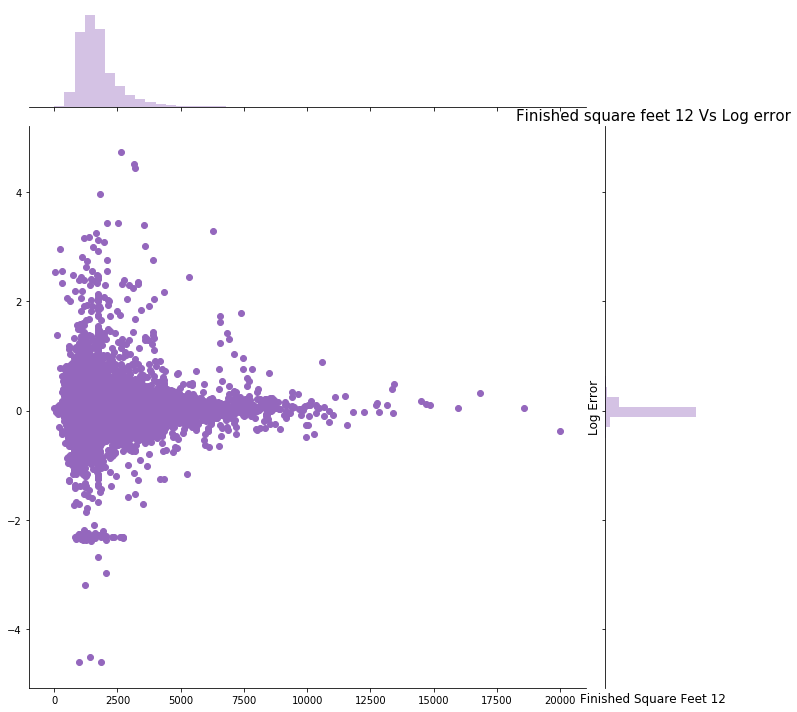

Mean of the 99.5 < percentile = 0.07382433628318584
Mean of the entire set = 0.011457219606757128


In [45]:
col = "calculatedfinishedsquarefeet"

ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, height=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

print("Mean of the 99.5 < percentile = {0}".format(np.mean(train_df.logerror.values[train_df[col]>ulimit])))
print("Mean of the entire set = {0}".format(np.mean(train_df.logerror.values)))

A few interesting points about the above plot and calculations.

As we saw in the histogram plot, much of the log errors are concentrated around zero, with some fairly scattered outliers off to the side. It seems that the square footage also follows this similar trend.

One very interesting thing to note however is the far right part of the plot and the calculations of the mean logerrors shown below the plot. The houses that have roughly greater than 5500 square feet have **7 times** the mean log error than that of the mean of the entire dataset! This proves our previous hypothesis made in the previous EDA that bigger houses tend to be harder to price estimate. 

### Bedroom count

<Figure size 864x864 with 0 Axes>

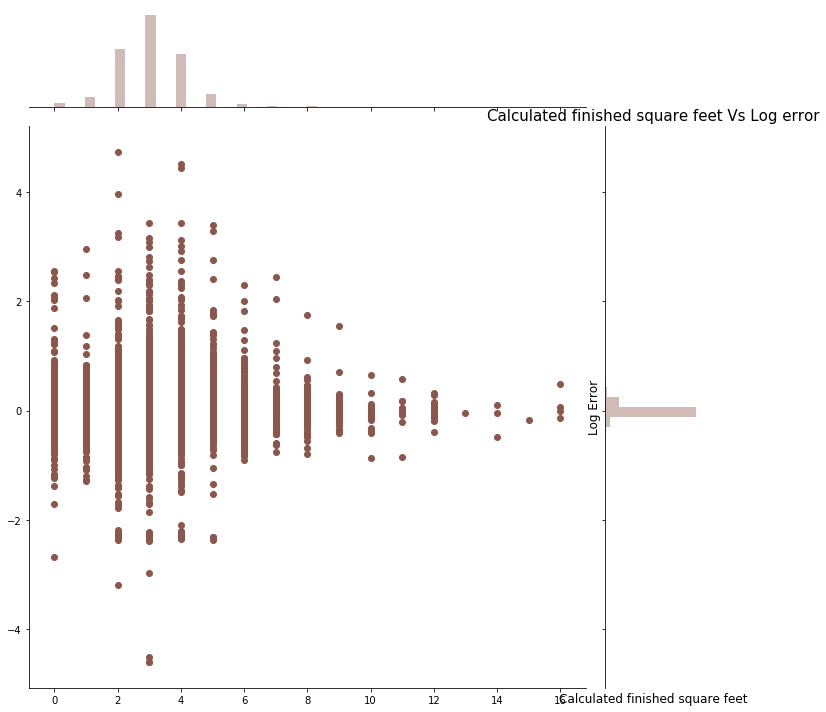

Mean of the 0 bedroom houses = 0.010944264602392683
Mean of the 1 bedroom houses = 0.01115866050808314
Mean of the 2 bedroom houses = 0.005348946638636668
Mean of the 3 bedroom houses = 0.010567655937032754
Mean of the 4 bedroom houses = 0.01552744218156714
Mean of the 5 bedroom houses = 0.024326334449478043
Mean of the 6 bedroom houses = 0.021984732142857143
Mean of the 7 bedroom houses = 0.05206880341880341
Mean of the entire set = 0.011457219606757128


In [46]:
col = "bedroomcnt"
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 0.5)

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.bedroomcnt.values, y=train_df.logerror.values, height=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

for i in range(8):
    print("Mean of the {0} bedroom houses = {1}".format(i, np.mean(train_df.logerror.values[train_df[col]==i])))
print("Mean of the entire set = {1}".format(i, np.mean(train_df.logerror.values)))

Nice.

If we check out the scatter plot we can see that we have a pretty normal distribution across the whole range, roughly speaking. BUT the last few to the right hand side do seem a bit shifted upward. We calculate and print the mean values of the log error for each number of bedrooms below the plot. As we can see, houses with 5, 6, and 7 bedrooms tend to yield much higher log error, more than double the mean, than the lower bedroom count houses. This further confirms our hypothesis of more expensive / bigger houses leads to higher error. 

### Bathroom count

<Figure size 864x864 with 0 Axes>

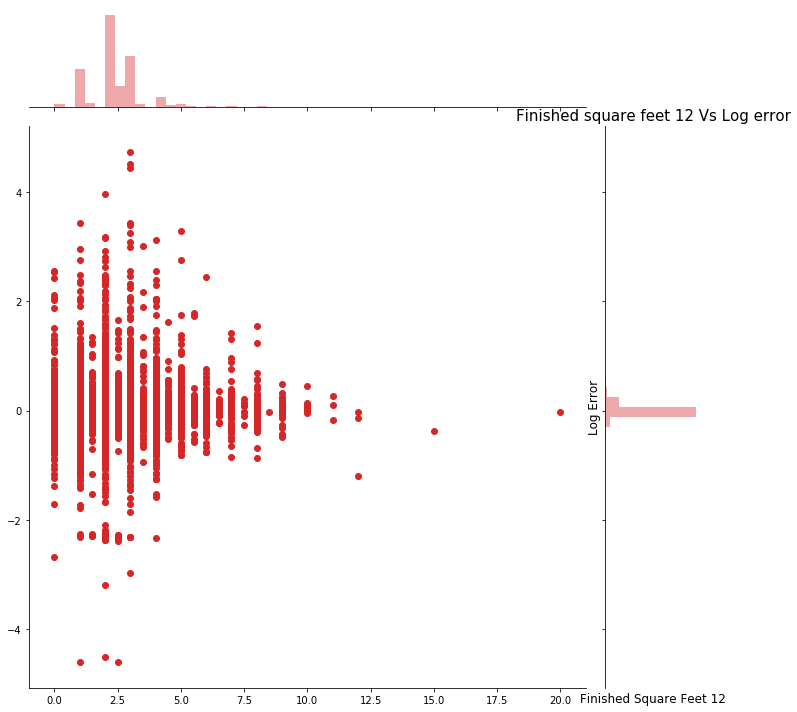

Mean of the 0 bathroom houses = 0.01060128755364807
Mean of the 1 bathroom houses = 0.0074163751247090124
Mean of the 2 bathroom houses = 0.009209514424919255
Mean of the 3 bathroom houses = 0.014577950466258899
Mean of the 4 bathroom houses = 0.01803884584557841
Mean of the 5 bathroom houses = 0.03728957968476357
Mean of the 6 bathroom houses = 0.018694642857142858
Mean of the entire set = 0.011457219606757128


In [47]:
col = "bathroomcnt"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.bathroomcnt.values, y=train_df.logerror.values, height=10, color=color[3])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

for i in range(7):
    print("Mean of the {0} bathroom houses = {1}".format(i, np.mean(train_df.logerror.values[train_df[col]==i])))
print("Mean of the entire set = {1}".format(i, np.mean(train_df.logerror.values)))

And surprise surprise, would you look at that.... it's the same trend! In fact, it's even strong with bathroom count! It seems that many bathrooms and bedrooms are both **very strong** indicators of getting a high error.

### Tax amount
Last but not least, let's look at the tax amount since it had a high magnitude but __negative__ correlation coefficient.

<Figure size 864x864 with 0 Axes>

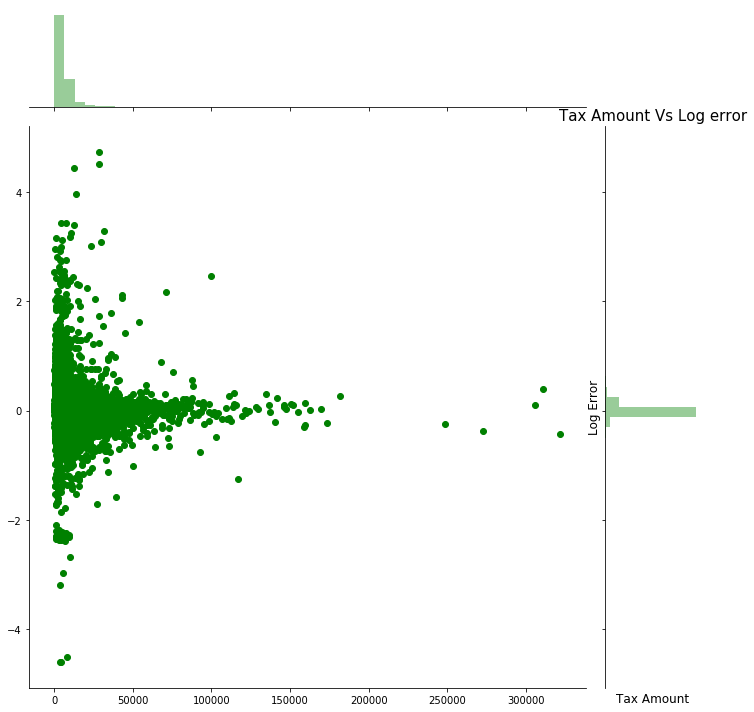

Mean of the 99.5 < percentile = 0.019494026548672563
Mean of the 0.5 > percentile = 0.05188561946902655
Mean of the entire set = 0.011457219606757128


In [48]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, height=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

print("Mean of the 99.5 < percentile = {0}".format(np.mean(train_df.logerror.values[train_df[col]>ulimit])))
print("Mean of the 0.5 > percentile = {0}".format(np.mean(train_df.logerror.values[train_df[col]<llimit])))
print("Mean of the entire set = {0}".format(np.mean(train_df.logerror.values)))

As we can see from both the plot and our calculations, the houses with higher taxes have a mean error very close to the mean across the dataset. BUT the houses with very low taxes (< 0.5 percentile) have a mean log error that is nearly **5 times** that of the mean. This again corresponds with the high-magnitude, negative correlation coefficient. Another one confirmed. 